# Simulation of noisy mutual inhibition
*Nhat Le, October 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def thresh_tanh(activity):
    '''Activation function for a neuron'''
    return 1 + np.tanh(activity)



def update_u_tanh(u, v, c1, dt):
    activation = u - (c1 * v) * dt
    #print(activation)
    return thresh_tanh(activation)

def update_v_tanh(u, v, c2, dt):
    activation = v - (c2 * u) * dt
    return thresh_tanh(activation)

def simulate_u_v_tanh(u_init, v_init, c1, c2, dt, niter):
    u_lst = []
    v_lst = []
    u = u_init
    v = v_init
    for i in range(niter):
        u = update_u_tanh(u, v, c1, dt)
        u_lst.append(u)
        v = update_v_tanh(u, v, c2, dt)
        v_lst.append(v)
    return u_lst, v_lst

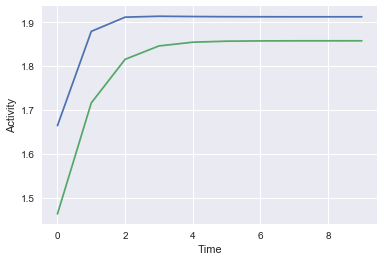

In [3]:
u1, v1 = simulate_u_v_tanh(1, 1, c1=2, c2=3, dt=0.1, niter=10)
plt.plot(u1)
plt.plot(v1);
plt.xlabel('Time')
plt.ylabel('Activity')

In [4]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def update_u_exp(u, v, c1, c2, c3, theta, tau, dt):
    du = (-u + thresh_exp(c3 * theta - c1 * v)) / tau * dt
    return u + du

def update_v_exp(u, v, c1, c2, c3, theta, tau, dt):
    dv = (-v + thresh_exp(c3 * theta - c2 * u)) / tau * dt
    return v + dv

def simulate_u_v_exp(u_init, v_init, c1, c2, c3, theta, tau, niter, dt):
    u_lst = []
    v_lst = []
    u = u_init
    v = v_init
    for i in range(niter):
        u = update_u_exp(u, v, c1, c2, c3, theta, tau, dt)
        #print('u = ', u)
        u_lst.append(u)
        v = update_v_exp(u, v, c1, c2, c3, theta, tau, dt)
        #print('v = ', v)
        v_lst.append(v)
    return u_lst, v_lst

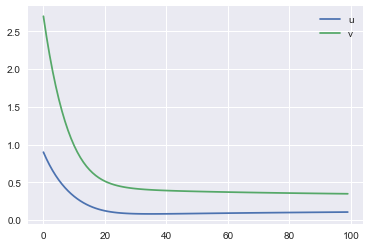

In [5]:
ulst, vlst = simulate_u_v_exp(1, 3, c1=6, c2=6, c3=6, theta=0,
                              tau=100, niter=100, dt=10)
plt.plot(ulst, label='u')
plt.plot(vlst, label='v')
plt.legend()

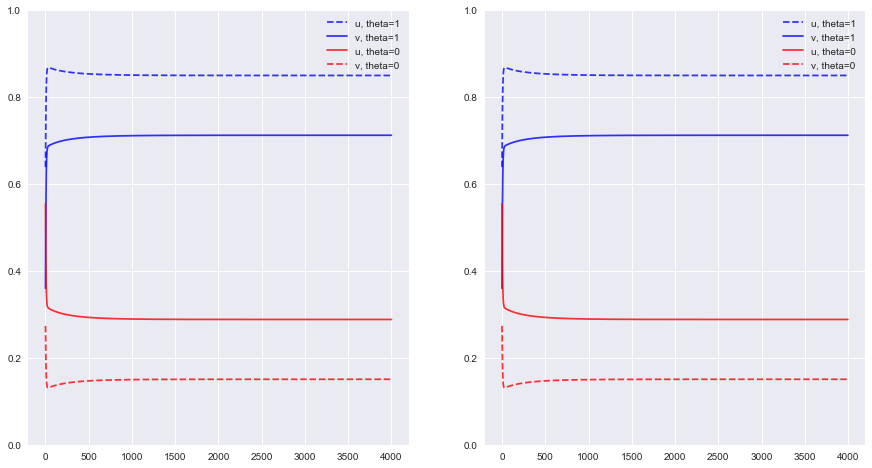

In [6]:
# The effect of theta on the fixed points
ulst1, vlst1 = simulate_u_v_exp(0.6, 0.3, c1=6, c2=6, c3=6, theta=1,
                              tau=100, niter=4000, dt=10)
ulst2, vlst2 = simulate_u_v_exp(0.6, 0.3, c1=6, c2=6, c3=6, theta=0,
                              tau=100, niter=4000, dt=10)

ulst1b, vlst1b = simulate_u_v_exp(0.6, 0.3, c1=6, c2=6, c3=6, theta=1,
                              tau=100, niter=4000, dt=10)
ulst2b, vlst2b = simulate_u_v_exp(0.6, 0.3, c1=6, c2=6, c3=6, theta=0,
                              tau=100, niter=4000, dt=10)


fig,ax = plt.subplots(1, 2, figsize=(15,8))
ax[0].plot(ulst1, '--', color='blue', alpha=0.8, label='u, theta=1')
ax[0].plot(vlst1, color='blue', alpha=0.8, label='v, theta=1')
ax[0].plot(ulst2, color='red', alpha=0.8, label='u, theta=0')
ax[0].plot(vlst2, '--', color='red', alpha=0.8, label='v, theta=0')


ax[0].set_ylim(0,1)
ax[0].legend();

ax[1].plot(ulst1b, '--', color='blue', alpha=0.8, label='u, theta=1')
ax[1].plot(vlst1b, color='blue', alpha=0.8, label='v, theta=1')
ax[1].plot(ulst2b, color='red', alpha=0.8, label='u, theta=0')
ax[1].plot(vlst2b, '--', color='red', alpha=0.8, label='v, theta=0')


ax[1].set_ylim(0,1)
ax[1].legend(loc='upper right');

## Add a 'Set' signal

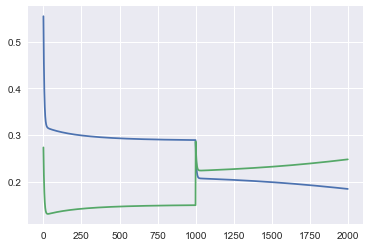

In [7]:
ulst, vlst = simulate_u_v_exp(0.6, 0.3, c1=6, c2=6, c3=6, theta=0,
                              tau=100, niter=1000, dt=10)
ulst_set, vlst_set = simulate_u_v_exp(ulst[-1], vlst[-1]+0.15, c1=6, c2=6, c3=6, theta=0,
                              tau=100, niter=1000, dt=10)
plt.plot(ulst + ulst_set)
plt.plot(vlst + vlst_set);
#plt.ylim((ulst[-1], vlst[-1]))


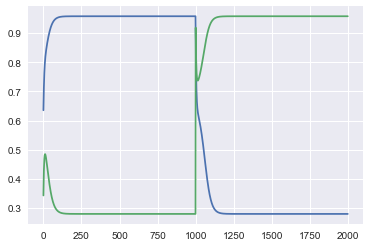

In [8]:
ulst, vlst = simulate_u_v_exp(0.6, 0.3, c1=6, c2=6, c3=6, theta=0.8,
                              tau=100, niter=1000, dt=10)
ulst_set, vlst_set = simulate_u_v_exp(ulst[-1], vlst[-1]+0.7, c1=6, c2=6, c3=6, theta=0.8,
                              tau=100, niter=1000, dt=10)
plt.plot(ulst + ulst_set)
plt.plot(vlst + vlst_set);

In [9]:
ulst, vlst = simulate_u_v_exp(0.6, 0.3, c1=6, c2=6, c3=6, theta=1,
                              tau=100, niter=4000, dt=10)
ulst_set, vlst_set = simulate_u_v_exp(ulst[-1], vlst[-1]+0.13, c1=6, c2=6, c3=6, theta=1,
                              tau=100, niter=8000, dt=10)


In [ ]:
ulst[-1]